In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import os
from sklearn.linear_model import lasso_path, enet_path
from sklearn.linear_model import ElasticNetCV, ElasticNet, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
from Stacking import *

/Users/yaowangyi/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [4]:
file_list = os.listdir('gt_f')

In [5]:
file = []
for i in file_list:
    data = pd.read_csv('gt_f/'+i,index_col='Week')
    data.index = pd.DatetimeIndex(data.index)
    file.append(data)
features = file[0]
for i in range(1,len(file)):
    features = features.join(file[i])

In [6]:
#features[:'2016-07-31']

In [7]:
features.shape

(661, 62)

In [8]:
#x_path = '/Users/yaowangyi/Desktop/data/gt_features/x_gt_data.xlsx'
y_path = '/Users/yaowangyi/Desktop/data/gt_features/y_gastroenteritis_eng.csv'


In [9]:
# gt_data = pd.read_excel(x_path,index_col ='Week')
# time_line = pd.date_range('2004-01-04',freq='7D', periods=657)
# gt_data.index = time_line
gt_data = features

In [10]:
#gt_data[:'2016-07-31']

In [11]:
rcgp_data = pd.read_csv(y_path,index_col='week')
time_line = pd.date_range('2004-01-04',freq='7D', periods=657)
rcgp_data.index = time_line

In [12]:
#rcgp_data
#rcgp_data['2004-09-01':]

In [13]:
#Correlation coefficient for features with RCGP data
corr_tab = rcgp_data.join(gt_data).corr()
#corr_tab

In [14]:
corr_tab.shape

(63, 63)

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [16]:
def metrics(y_true,y_pred):
    corr_table = y_true.join(y_pred).corr()
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r = corr_table.values[1][0]
    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = mean_absolute_error(y_true,y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # r_squared = r2_score(y_true,y_pred)
    metrics_table = pd.DataFrame(np.arange(5).reshape((1,5)),columns=['r','MSE','RMSE','MAE','MAPE'])
    metrics_table['r'] = r
    metrics_table['MSE'] = mse
    metrics_table['RMSE'] = rmse
    metrics_table['MAE'] = mae
    metrics_table['MAPE'] = mape
    # metrics_table['R_square'] = r_squared
    return metrics_table

### First prediction

In [313]:
# 2004.9.1-2009.9.1 -> 2009.9.1-2010.9.1
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


train_line_1 = pd.date_range(start= '2004-09-01', end='2009-09-01')
test_line_1 = pd.date_range(start='2009-09-01',end = '2010-09-01')
x_train_1 = gt_data.loc[train_line_1,:].dropna(0)
y_train_1 = rcgp_data.loc[train_line_1,:].dropna(0)
x_test_1 = gt_data.loc[test_line_1,:].dropna(0)
y_test_1 = rcgp_data.loc[test_line_1,:].dropna(0)

#grid search
#parameters = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'l1_ratio':[0.5]}
#parameters = {'alpha': [0,10,20,30,40,50,60,70,80,90,100],'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] }
#parameters = {'alpha': [0,50,100],'l1_ratio':np.arange(0,1,0.1) }
#parameters = {'alpha': np.arange (1,100,0.1),'l1_ratio':[0.5]]}
parameters = {'alpha':[4.0],'l1_ratio':[0.5]}

mycv_1 = TimeSeriesSplit(n_splits =5)
#clf_1 = GridSearchCV(ElasticNet(fit_intercept= False),param_grid=parameters,scoring=make_scorer(mean_squared_error))
clf_1 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_1.fit(X = x_train_1, y = y_train_1)
predict_y_1 = clf_1.best_estimator_.predict(x_test_1)

In [314]:
clf_1.best_params_

{'alpha': 4.0, 'l1_ratio': 0.5}

In [315]:
weight_1 = clf_1.best_estimator_.coef_
pd.DataFrame(weight_1.reshape(1,62), columns= x_train_1.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.000643,-0.0,-0.0,-0.0,-0.0,0.0,-0.00597,-0.01397,0.0,0.0,0.028112,0.0,0.018456,-0.0,0.011609,0.0,-0.001149,0.0,0.0,-0.0,-0.0,0.005598,-0.003794,-0.002147,-0.004899,0.014172,-0.0,-0.0,0.025156,0.008968,0.004979,0.0,-0.0,-0.015169,0.0,-0.0,-0.0,0.003276,-0.0,-0.0,0.0,0.0,0.018691,-0.0,0.010961,-0.0,-0.0,0.0,0.05467,-0.0,0.0,-0.0,0.0,-0.000271,0.0,-0.014748,0.015747,0.0,0.015354,0.0,-0.0,-0.007467


In [316]:
predict_y_1

array([ 11.96581189,  13.60504115,  13.11574249,  13.40723893,
        14.17323356,  13.00772441,  13.93541713,  12.75088674,
        13.82788536,  13.81355734,  14.72699255,  13.69115388,
        13.35558378,  14.14558093,  13.93866377,  13.68753036,
        13.42888278,  14.03242391,  15.56513285,  14.2024783 ,
        14.45139469,  14.47060775,  14.36176797,  15.49075135,
        15.24762578,  16.65286659,  15.7176136 ,  15.93351163,
        16.93932261,  13.95661646,  14.14814898,  13.68695778,
        14.38819569,  13.670396  ,  14.82952064,  15.24205063,
        13.681429  ,  13.02324042,  12.79932145,  13.47582327,
        12.71571949,  13.07386253,  11.95710453,  12.70901524,
        12.95988305,  12.29740035,  12.7849194 ,  12.09368793,
        13.89588825,  12.50428253,  12.7016139 ,  13.20661949])

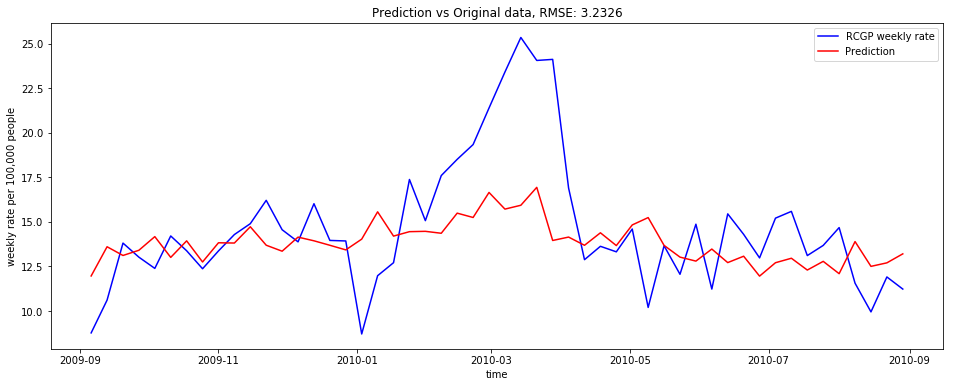

In [317]:
df1_gs = pd.DataFrame(predict_y_1, index=y_test_1.index, columns=['Prediction'])
#df1_gs
plt.plot(y_test_1, color='blue',label='RCGP weekly rate')
plt.plot(df1_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_1_gs = np.sqrt(np.mean((y_test_1.values - df1_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_1_gs)

In [318]:
mse_1 = mean_squared_error(y_test_1,df1_gs)
mse_1

10.44961311534677

In [319]:
mae_1 = mean_absolute_error(y_test_1,df1_gs)
mae_1

2.3050033770802743

In [320]:
metrics(y_test_1,df1_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.598206,10.449613,3.232586,2.305003,15.193491


In [321]:
y_train_1.values.shape

(261, 1)

In [322]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
lr = LinearRegression()
#srm = StackingCVRegressor(regressors=[rm1, rm2, rm3], meta_regressor=lr, cv=3)
srm = StackingCVRegressor(regressors=[clf_1, rm1, rm2], meta_regressor=lr, cv=3)

In [323]:
from sklearn.model_selection import cross_val_score

srm.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
rm1.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
rm2.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
rm3.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

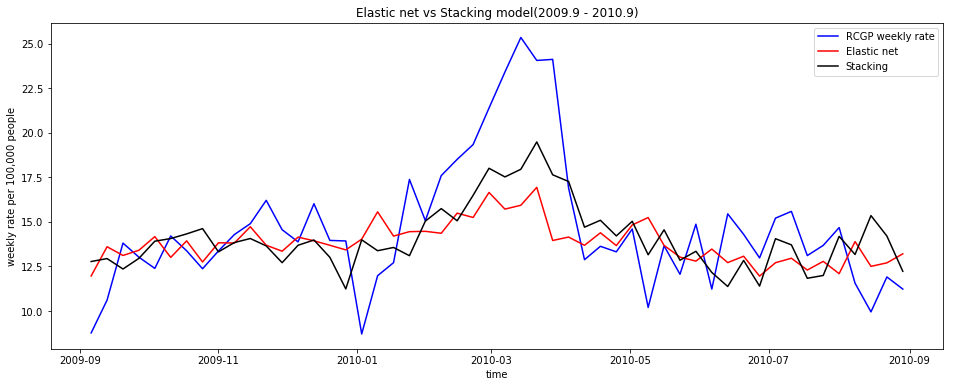

In [324]:
pre = rm2.predict(x_test_1.values)
df1 = pd.DataFrame(pre, index=y_test_1.index, columns=['Prediction'])
#df1
plt.plot(y_test_1, color='blue',label='RCGP weekly rate')
plt.plot(df1_gs, color='red',label='Elastic net')
plt.plot(df1, color = 'black', label = 'Stacking')

plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_1_gs = np.sqrt(np.mean((y_test_1.values - df1.values)**2))
plt.title('Elastic net vs Stacking model(2009.9 - 2010.9)')

In [325]:
mse_1 = mean_squared_error(y_test_1,df1)
mse_1

7.3054256153846122

In [326]:
mae_1 = mean_absolute_error(y_test_1,df1)
mae_1

2.0773461538461535

In [327]:
metrics(y_test_1,df1)

,r,MSE,RMSE,MAE,MAPE
0,0.733934,7.305426,2.702855,2.077346,14.353445


### second prediction

In [328]:
# 2004.9.1-2010.9.1 (6 years) -> 2010.9.1-2011.9.1 (1 year)
train_line_2 = pd.date_range(start= '2004-09-01', end='2010-09-01')
test_line_2 = pd.date_range(start='2010-09-01',end = '2011-09-01')
x_train_2 = gt_data.loc[train_line_2,:].dropna(0)
y_train_2 = rcgp_data.loc[train_line_2,:].dropna(0)
x_test_2 = gt_data.loc[test_line_2,:].dropna(0)
y_test_2 = rcgp_data.loc[test_line_2,:].dropna(0)
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
parameters = {'alpha':[3],'l1_ratio':[0.5]}
mycv2 = TimeSeriesSplit(n_splits =6)

#clf_2 = GridSearchCV(ElasticNet(fit_intercept= False), param_grid=parameters, cv = mycv2, scoring=make_scorer(mean_squared_error))

# rmse = 2.7503  Trend is not very significant, prediction is above the ground truth
clf_2 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_2.fit(X = x_train_2, y = y_train_2)

predict_y_2 = clf_2.best_estimator_.predict(x_test_2)
predict_y_2

clf_2.best_params_

{'alpha': 3, 'l1_ratio': 0.5}

In [329]:
weight_2 = clf_2.best_estimator_.coef_
pd.DataFrame(weight_2.reshape(1,62), columns= x_train_2.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.002929,-0.015152,0.002182,-0.005451,-0.0,0.0,-0.0,-0.014418,0.0,0.002435,0.039125,0.000114,0.016619,-0.009898,0.011812,0.0,-0.005925,0.0,0.0,-0.0,0.0,0.029979,-0.0,-0.002373,-0.0044,0.013843,-0.0,-0.000999,0.022395,0.0,0.004096,0.0,-0.0,-0.0,-0.0,-0.006002,-0.0,0.006205,-0.0,-0.0,-0.0,-0.0,0.013959,-0.003016,0.025266,-0.0,0.0,0.0,0.082588,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.013022,0.0253,0.0,0.013167,0.0,-0.0,-0.009577


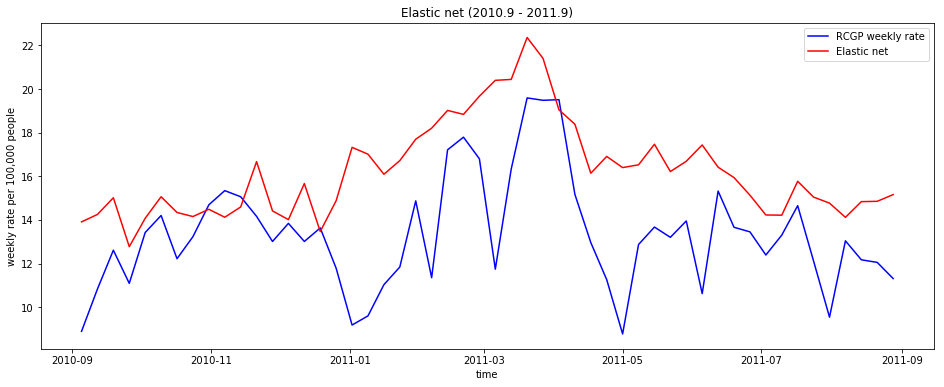

In [330]:
df2_gs = pd.DataFrame(predict_y_2, index = y_test_2.index, columns=['Prediction'])
plt.plot(y_test_2, color='blue',label='RCGP weekly rate')
plt.plot(df2_gs, color = 'red', label = 'Elastic net')

plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_2_gs = np.sqrt(np.mean((y_test_2.values - df2_gs.values)**2))
mse_2 = mean_squared_error(y_test_2,df2_gs)

plt.title('Elastic net (2010.9 - 2011.9)')


In [331]:
mean_absolute_error(y_test_2,df2_gs)

2.9794115021513878

In [332]:
mean_squared_error(y_test_2,df2_gs)

13.518150649219036

In [333]:
metrics(y_test_2,df2_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.53086,13.518151,3.676704,2.979412,25.313326


In [334]:
# rm1 = Lasso()
# rm2 = Ridge()
# rm3 = XGBRegressor()

rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
srm = StackingCVRegressor(regressors=[clf_2, rm1,rm2], meta_regressor=lr, cv=3)

In [335]:
from sklearn.model_selection import cross_val_score

# rm1.fit(X=x_train_2.values,y=y_train_2.values.reshape(313,))
# rm2.fit(X=x_train_2.values,y=y_train_2.values.reshape(313,))
# rm3.fit(X=x_train_2.values,y=y_train_2.values.reshape(313,))
# srm.fit(X=x_train_2.values,y=y_train_2.values.reshape(313,))

rm1.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
rm2.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
#rm3.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))
srm.fit(X=x_train_1.values,y=y_train_1.values.reshape(261,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

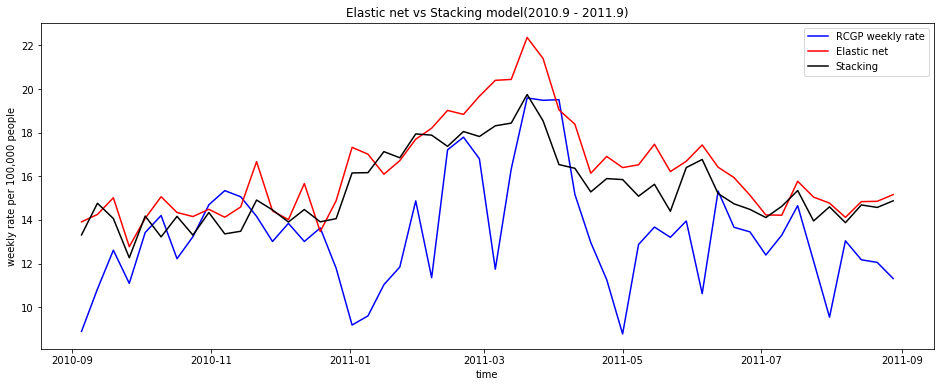

In [336]:
pre2 = srm.predict(x_test_2.values)
df2 = pd.DataFrame(pre2, index=y_test_2.index, columns=['Prediction'])
#df1
plt.plot(y_test_2, color='blue',label='RCGP weekly rate')
plt.plot(df2_gs, color = 'red', label = 'Elastic net')
plt.plot(df2, color = 'black', label = 'Stacking')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_2_gs = np.sqrt(np.mean((y_test_2.values - df2.values)**2))
plt.title('Elastic net vs Stacking model(2010.9 - 2011.9)')

In [337]:
mean_absolute_error(y_test_2,df2)

2.4001654013387541

In [338]:
mean_squared_error(y_test_2,df2)

9.9935138685956506

In [339]:
metrics(y_test_2,df2)

,r,MSE,RMSE,MAE,MAPE
0,0.402301,9.993514,3.161252,2.400165,20.898444


### 3rd prediction

In [286]:
# 2004.9.1-2011.9.1 (7 years) -> 2011.9.1-2012.9.1 (1 year)
train_line_3 = pd.date_range(start= '2004-09-01', end='2011-09-01')
test_line_3 = pd.date_range(start='2011-09-01',end = '2012-09-01')
x_train_3 = gt_data.loc[train_line_3,:].dropna(0)
y_train_3 = rcgp_data.loc[train_line_3,:].dropna(0)
x_test_3 = gt_data.loc[test_line_3,:].dropna(0)
y_test_3 = rcgp_data.loc[test_line_3,:].dropna(0)


In [300]:
# 2004.9.1-2011.9.1 -> 2011.9.1-2012.9.1
from sklearn.model_selection import GridSearchCV
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
parameters = {'alpha':[2.5],'l1_ratio':[0.5]}
mycv3 = TimeSeriesSplit(n_splits =7)
#clf = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv3)
clf_3 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_3.fit(X = x_train_3, y = y_train_3)
predict_y_3 = clf_3.best_estimator_.predict(x_test_3)
predict_y_3

array([ 12.52840726,  13.28086585,  12.93446547,  13.006321  ,
        11.45602893,  13.20364653,  12.83051421,  13.52294721,
        13.04063017,  14.45598053,  14.77937049,  14.06910608,
        12.91081608,  13.93351544,  14.53749454,  13.63374268,
        14.51622613,  13.91996895,  14.97925748,  14.42269196,
        14.80648369,  15.81598719,  14.86524896,  15.24231245,
        17.02367217,  17.70290703,  17.20191745,  17.17454188,
        20.12814759,  17.08388469,  15.37764498,  15.37013182,
        15.2257664 ,  15.05122052,  15.92945808,  13.86391357,
        14.76249146,  12.41838979,  13.58440146,  11.61321672,
        12.39398349,  12.63665367,  13.52003177,  12.28896455,
        13.40918602,  11.81748075,  12.53036229,  11.89373282,
        11.76152876,  11.33564017,  10.96450811,  12.0110964 ])

In [301]:
clf_3.best_params_

{'alpha': 2.5, 'l1_ratio': 0.5}

In [302]:
weight_3 = clf_3.best_estimator_.coef_
pd.DataFrame(weight_3.reshape(1,62), columns= x_train_3.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.006357,-0.048853,0.000397,-0.005518,-0.003581,-0.0,-0.0,-0.023971,0.000178,0.001672,0.040565,0.0,0.011223,-0.013283,0.010883,0.0,-0.020779,-0.0,-0.0,0.0,-0.0,0.025981,0.0,-0.000544,-0.005491,0.01573,-0.001732,-0.000202,0.001414,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.001355,0.0,0.005031,0.0,-0.000867,-0.0,-0.00034,0.015185,-0.0,0.031068,-0.000657,0.000415,0.0,0.070667,-0.004424,-0.0,-0.0,0.013994,0.0,-0.000127,-0.010581,0.017777,0.0,0.01049,0.0,-0.001019,-0.009165


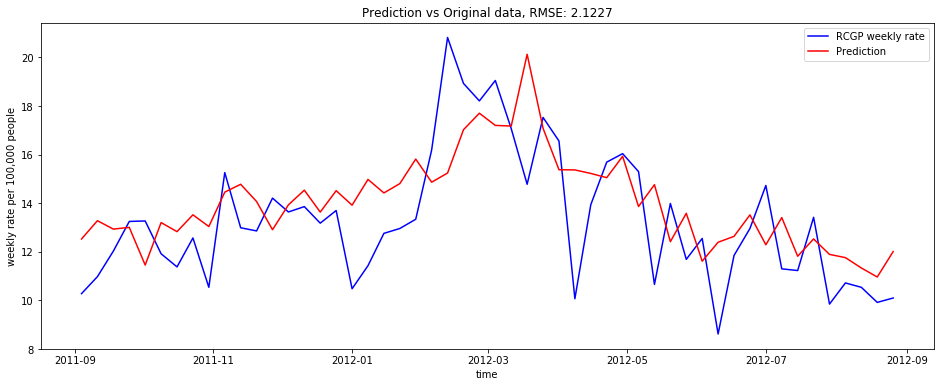

In [303]:
df3_gs = pd.DataFrame(predict_y_3, index=y_test_3.index, columns=['Prediction'])
plt.plot(y_test_3, color='blue',label='RCGP weekly rate')
plt.plot(df3_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_3_gs = np.sqrt(np.mean((y_test_3.values - df3_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_3_gs)

In [304]:
mean_absolute_error(y_test_3,df3_gs)

1.683122770793678

In [305]:
mean_squared_error(y_test_3,df3_gs)

4.5060532748782656

In [306]:
metrics(y_test_3,df3_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.660853,4.506053,2.122747,1.683123,13.59856


In [307]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()

srm = StackingCVRegressor(regressors=[clf_3, rm1,rm2], meta_regressor=lr, cv=3)

In [308]:
from sklearn.model_selection import cross_val_score

rm1.fit(X=x_train_3.values,y=y_train_3.values.reshape(365,))
rm2.fit(X=x_train_3.values,y=y_train_3.values.reshape(365,))
rm3.fit(X=x_train_3.values,y=y_train_3.values.reshape(365,))
srm.fit(X=x_train_3.values,y=y_train_3.values.reshape(365,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

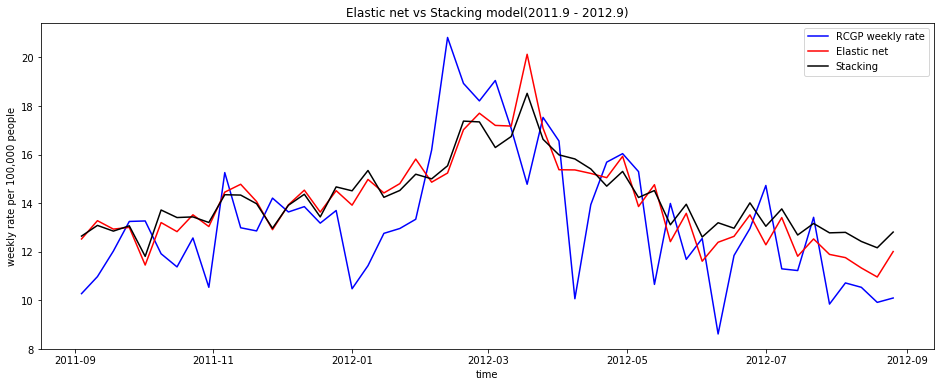

In [309]:
pre3 = srm.predict(x_test_3.values)
df3 = pd.DataFrame(pre3, index=y_test_3.index, columns=['Prediction'])

plt.plot(y_test_3, color='blue',label='RCGP weekly rate')
plt.plot(df3_gs, color = 'red', label = 'Elastic net')
plt.plot(df3, color = 'black', label = 'Stacking')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_3_gs = np.sqrt(np.mean((y_test_3.values - df3.values)**2))
plt.title('Elastic net vs Stacking model(2011.9 - 2012.9)')

In [310]:
mean_absolute_error(y_test_3,df3)

1.7787808482781498

In [311]:
mean_squared_error(y_test_3,df3)

4.8433066859194716

In [312]:
metrics(y_test_3,df3)

,r,MSE,RMSE,MAE,MAPE
0,0.664767,4.843307,2.200751,1.778781,14.701922


### 4th prediction

In [340]:
train_line_4 = pd.date_range(start= '2004-09-01', end='2012-09-01')
test_line_4 = pd.date_range(start='2012-09-01',end = '2013-09-01')
x_train_4 = gt_data.loc[train_line_4,:].dropna(0)
y_train_4 = rcgp_data.loc[train_line_4,:].dropna(0)
x_test_4 = gt_data.loc[test_line_4,:].dropna(0)
y_test_4 = rcgp_data.loc[test_line_4,:].dropna(0)


In [341]:
# 2004.9.1-2012.9.1 -> 2012.9.1-2013.9.1
from sklearn.model_selection import GridSearchCV
#parameters = {'alpha':[0,10,20,30,40,50,60,70,80,90,100],'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
parameters = {'alpha':[4],'l1_ratio':[0.5]}
mycv4 = TimeSeriesSplit(n_splits =8)
#clf_4 = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv4)
clf_4 =GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_4.fit(X = x_train_4, y = y_train_4)
predict_y_4 = clf_4.best_estimator_.predict(x_test_4)
predict_y_4

array([ 10.43201791,  10.84712553,  11.23229815,  11.06033536,
        10.70667659,  11.0281111 ,  10.95035403,  11.02633233,
        11.83083941,  12.20320427,  11.58966505,  11.52768083,
        11.57837099,  11.0432479 ,  11.35847664,  10.63633028,
        10.9546829 ,  10.85160138,   9.87782701,  10.74110958,
        11.14248345,  12.92941349,  12.19756492,  10.93586418,
        12.21315491,  13.2681686 ,  13.835301  ,  12.91217966,
        14.61442564,  13.64324722,  13.94440766,  12.94457211,
        12.05814748,  12.06297006,  11.6888803 ,  11.19072364,
        10.91019814,  11.20007108,  11.37430233,  10.81071816,
        10.07434737,  10.31991493,  10.92261888,  10.36104436,
        10.50282155,  15.09700747,  10.69402833,  10.90329805,
        10.33792213,  10.8848194 ,  10.26866388,  10.78060942,  10.30361096])

In [342]:
clf_4.best_params_

{'alpha': 4, 'l1_ratio': 0.5}

In [343]:
weight_4 = clf_4.best_estimator_.coef_
pd.DataFrame(weight_4.reshape(1,62), columns= x_train_4.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.0,-0.044257,0.0,-0.003146,-0.006369,0.0,-0.0,-0.016703,0.0,0.000846,0.032891,0.0,0.007896,-0.015531,0.007332,0.0,-0.016157,0.0,-0.0,-0.0,-0.0,0.015566,0.0,-0.0,-0.000844,0.006912,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.004415,-0.0,-0.0,-0.0,-0.0,0.01122,-0.0,0.03485,-0.0,0.0,-0.0,0.048956,-0.000309,0.0,-0.0,0.0,0.0,-0.0,-0.007465,0.012119,0.0,0.000255,0.0,0.0,-0.004721


In [344]:
weight_4

array([-0.        , -0.04425719,  0.        , -0.00314617, -0.00636898,
        0.        , -0.        , -0.016703  ,  0.        ,  0.00084571,
        0.03289099,  0.        ,  0.00789627, -0.01553053,  0.00733238,
        0.        , -0.01615724,  0.        , -0.        , -0.        ,
       -0.        ,  0.01556607,  0.        , -0.        , -0.00084441,
        0.00691167, -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.00441466, -0.        , -0.        ,
       -0.        , -0.        ,  0.01122014, -0.        ,  0.03485041,
       -0.        ,  0.        , -0.        ,  0.04895594, -0.00030883,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.00746492,  0.01211915,  0.        ,  0.00025473,  0.        ,
        0.        , -0.00472096])

In [345]:
np.sum(weight_4!=0)

22

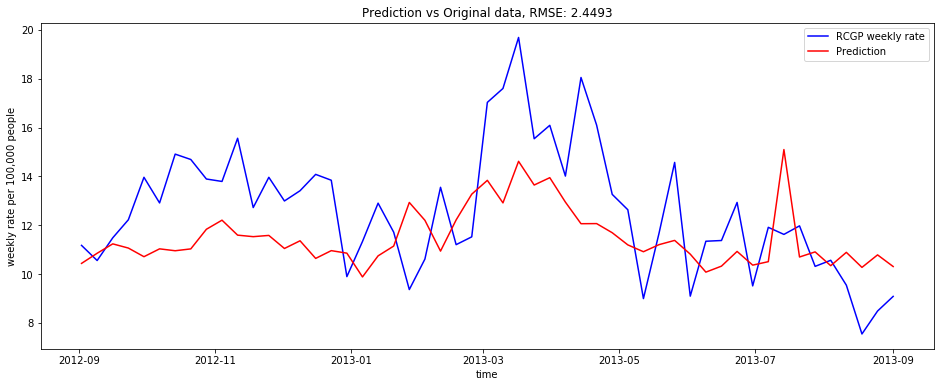

In [346]:
df4_gs = pd.DataFrame(predict_y_4, index=y_test_4.index, columns=['Prediction'])
plt.plot(y_test_4, color='blue',label='RCGP weekly rate')
plt.plot(df4_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_4_gs = np.sqrt(np.mean((y_test_4.values - df4_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_4_gs)

In [347]:
mean_absolute_error(y_test_4,df4_gs)

2.0858530064296885

In [348]:
mean_squared_error(y_test_4,df4_gs)

5.9992474092375323

In [349]:
metrics(y_test_4,df4_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.527274,5.999247,2.449336,2.085853,16.097235


In [350]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
lr = LinearRegression()
srm = StackingCVRegressor(regressors=[clf_4, rm1,rm2], meta_regressor=lr, cv=3)

In [351]:
from sklearn.model_selection import cross_val_score

rm1.fit(X=x_train_4.values,y=y_train_4.values.reshape(417,))
rm2.fit(X=x_train_4.values,y=y_train_4.values.reshape(417,))
rm3.fit(X=x_train_4.values,y=y_train_4.values.reshape(417,))
srm.fit(X=x_train_4.values,y=y_train_4.values.reshape(417,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

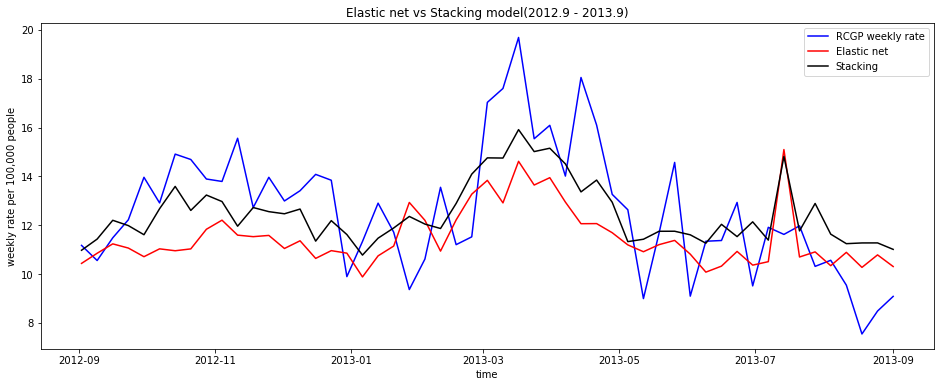

In [352]:
pre4 = srm.predict(x_test_4.values)
df4 = pd.DataFrame(pre4, index=y_test_4.index, columns=['Prediction'])

plt.plot(y_test_4, color='blue',label='RCGP weekly rate')
plt.plot(df4_gs, color = 'red', label = 'Elastic net')
plt.plot(df4, color = 'black', label = 'Stacking')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_4_gs = np.sqrt(np.mean((y_test_4.values - df4.values)**2))
plt.title('Elastic net vs Stacking model(2012.9 - 2013.9)')

In [353]:
mean_absolute_error(y_test_4,df4)

1.5892322313549119

In [354]:
mean_squared_error(y_test_4,df4)

3.8278797342675075

In [355]:
metrics(y_test_4,df4)

,r,MSE,RMSE,MAE,MAPE
0,0.669922,3.82788,1.956497,1.589232,13.198701


### 5th prediction

In [444]:
# 2004.9.1-2013.9.1 (9 years) -> 2013.9.1-2014.9.1 (1 year)
train_line_5 = pd.date_range(start= '2004-09-02', end='2013-09-01')
test_line_5 = pd.date_range(start='2013-09-02',end = '2014-09-01')
x_train_5 = gt_data.loc[train_line_5,:].dropna(0)
y_train_5 = rcgp_data.loc[train_line_5,:].dropna(0)
x_test_5 = gt_data.loc[test_line_5,:].dropna(0)
y_test_5 = rcgp_data.loc[test_line_5,:].dropna(0)


In [445]:
# 2004.9.1-2013.9.1 -> 2013.9.1-2014.9.1
from sklearn.model_selection import GridSearchCV
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
# parameters = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.8,0.9],'l1_ratio':[0.1,0.5,0.9]}
parameters = {'alpha':[1],'l1_ratio':[0.5]}
mycv5 = TimeSeriesSplit(n_splits = 9)
#clf = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv5)
clf_5 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_5.fit(X = x_train_5, y = y_train_5)
predict_y_5 = clf_5.best_estimator_.predict(x_test_5)
predict_y_5

array([ 11.77671683,  10.76181083,  10.73340293,  11.34701839,
        11.19874068,  10.43963758,  11.02627359,  11.29006439,
        11.57639315,  11.49957454,  12.70086429,  12.73317774,
        13.02019977,  12.94825475,  12.22364345,  10.54829516,
        11.42497392,  11.88327068,  11.53371646,  11.67037662,
        12.01411458,  13.22749789,  13.03540554,  13.2608406 ,
        13.67818537,  12.25268563,  13.80733326,  15.03429378,
        13.23155464,  13.28243545,  12.54719321,  11.36571602,
        12.43130652,  12.24549598,  11.45784407,  12.26175957,
        11.56374956,  11.13703867,  10.928459  ,  10.90838628,
        10.13598507,  10.36583327,  11.84210294,  10.73505832,
        10.16446374,  11.80579458,   9.91930205,  11.81293714,
         9.44820337,  11.19655279,  10.56864449,  11.05080035])

In [446]:
clf_5.best_params_

{'alpha': 1, 'l1_ratio': 0.5}

In [447]:
weight_5 = clf_5.best_estimator_.coef_
pd.DataFrame(weight_5.reshape(1,62), columns= x_train_5.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.003653,-0.049963,0.000521,-0.008275,-0.004871,-0.000442,-0.0,-0.026429,0.003323,0.005245,0.045456,0.006098,0.01538,-0.019555,0.021659,0.00708,-0.023366,0.000542,0.0,0.005792,0.0,0.02779,-0.00021,-0.0,-0.005833,0.014025,-0.00334,-0.000651,0.0,0.0,0.001683,0.0,-0.002285,0.0,0.0,-0.0,-0.000385,0.01109,0.002348,-0.002098,-0.009336,-0.0,0.010429,-0.00552,0.027041,-0.005843,0.002188,0.0,0.081789,-0.01296,0.001718,0.002922,0.018912,0.007654,-0.004896,-0.00876,0.011106,0.004205,0.012266,0.011085,-0.009223,-0.004826


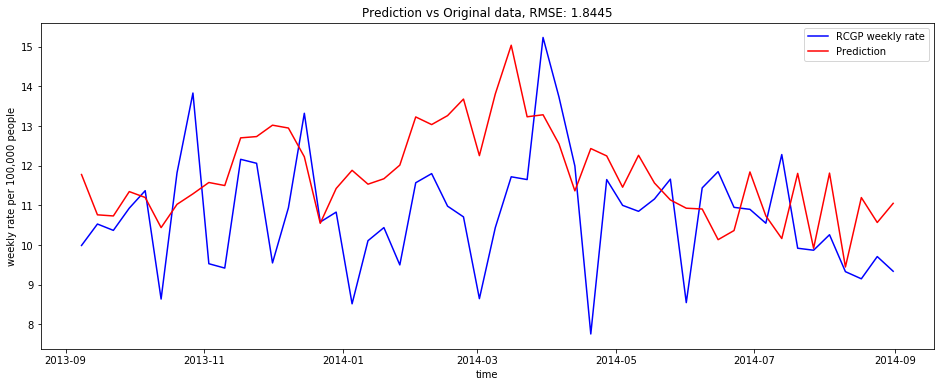

In [448]:
df5_gs = pd.DataFrame(predict_y_5, index=y_test_5.index, columns=['Prediction'])
plt.plot(y_test_5, color='blue',label='RCGP weekly rate')
plt.plot(df5_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_5_gs = np.sqrt(np.mean((y_test_5.values - df5_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_5_gs)

In [449]:
mean_absolute_error(y_test_5,df5_gs)

1.4937546453174042

In [450]:
mean_squared_error(y_test_5,df5_gs)

3.4020085235526492

In [451]:
metrics(y_test_5,df5_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.249859,3.402009,1.844453,1.493755,14.6248


In [452]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
lr = LinearRegression()
srm = StackingCVRegressor(regressors=[clf_5, rm1,rm2], meta_regressor=lr, cv=3)

In [453]:
from sklearn.model_selection import cross_val_score

rm1.fit(X=x_train_5.values,y=y_train_5.values.reshape(470,))
rm2.fit(X=x_train_5.values,y=y_train_5.values.reshape(470,))
rm3.fit(X=x_train_5.values,y=y_train_5.values.reshape(470,))
srm.fit(X=x_train_5.values,y=y_train_5.values.reshape(470,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

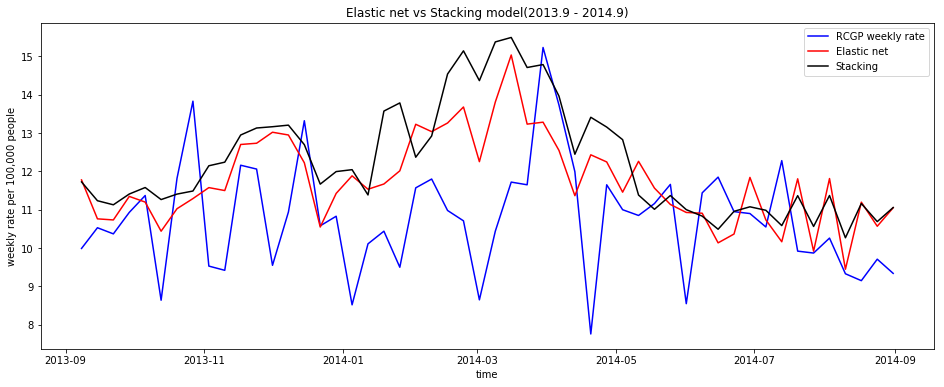

In [454]:
pre5 = srm.predict(x_test_5.values)
df5 = pd.DataFrame(pre5, index=y_test_5.index, columns=['Prediction'])

plt.plot(y_test_5, color='blue',label='RCGP weekly rate')
plt.plot(df5_gs, color = 'red', label = 'Elastic net')
plt.plot(df5, color = 'black', label = 'Stacking')

plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_5_gs = np.sqrt(np.mean((y_test_5.values - df5.values)**2))
plt.title('Elastic net vs Stacking model(2013.9 - 2014.9)')

In [455]:
mean_absolute_error(y_test_5,df5)

1.7622456009572065

In [456]:
mean_squared_error(y_test_5,df5)

5.2677577248991962

In [457]:
metrics(y_test_5,df5)

,r,MSE,RMSE,MAE,MAPE
0,0.21332,5.267758,2.29516,1.762246,17.575747


### 6th prediction

In [458]:
# 2004.9.1-2014.9.1 (10 years) -> 2014.9.1-2015.9.1 (1 year)
train_line_6 = pd.date_range(start= '2004-09-01', end='2014-09-01')
test_line_6 = pd.date_range(start='2014-09-01',end = '2015-09-01')
x_train_6 = gt_data.loc[train_line_6,:].dropna(0)
y_train_6 = rcgp_data.loc[train_line_6,:].dropna(0)
x_test_6 = gt_data.loc[test_line_6,:].dropna(0)
y_test_6 = rcgp_data.loc[test_line_6,:].dropna(0)


In [472]:
# 2004.9.1-2014.9.1 -> 2014.9.1-2015.9.1
from sklearn.model_selection import GridSearchCV
# parameters = {'alpha':[0,10,20,30,40,50,60,70,80,90,100],'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
parameters = {'alpha':[3],'l1_ratio':[0.5]}
mycv6 = TimeSeriesSplit(n_splits = 10)
#clf = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv6)
clf_6 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_squared_error))
clf_6.fit(X = x_train_6, y = y_train_6)
predict_y_6 = clf_6.best_estimator_.predict(x_test_6)
predict_y_6

array([ 10.88702109,  10.65443613,  10.73343187,  11.39540512,
        10.67456526,  10.67536488,  11.2431656 ,  10.93116839,
        11.66641187,  10.75551335,  11.55159096,  11.01425994,
        11.38256414,  12.16518954,  11.0332412 ,  11.05857272,
        10.40606506,  11.58053442,  11.30473187,  11.63364701,
        12.06783709,  12.02128503,  11.55625437,  12.06921981,
        12.62664613,  13.44262902,  12.93247138,  14.62549835,
        13.4443951 ,  12.38191358,  12.60363129,  12.21726279,
        12.39475975,  11.56951928,  12.24643941,  11.28122199,
        11.04695886,  10.69575731,  10.85581855,  10.94182462,
        11.3789444 ,  10.25629242,   9.95873424,  10.18024751,
         9.8753925 ,   9.34226038,  10.37126958,  10.38811852,
         9.47103944,   9.58469421,  10.1611502 ,  10.39219269])

In [473]:
clf_6.best_params_

{'alpha': 3, 'l1_ratio': 0.5}

In [474]:
weight_6 = clf_6.best_estimator_.coef_
pd.DataFrame(weight_6.reshape(1,62), columns= x_train_6.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.0,-0.040129,0.0,-0.001052,-0.006394,0.0,-0.000263,-0.015998,0.0,0.00048,0.034231,0.0,0.009111,-0.020702,0.007852,0.000359,-0.017654,0.0,-0.0,-0.0,-0.0,0.022668,0.0,0.0,-0.0,0.005733,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.005309,0.0,-0.0,-0.007512,-0.0,0.007918,-0.003979,0.029627,-0.000363,0.0,-0.0,0.057677,-0.000479,0.0,0.0,0.0,0.000005,-0.0,-0.004213,0.005032,0.000112,0.0,0.008133,0.0,-0.00228


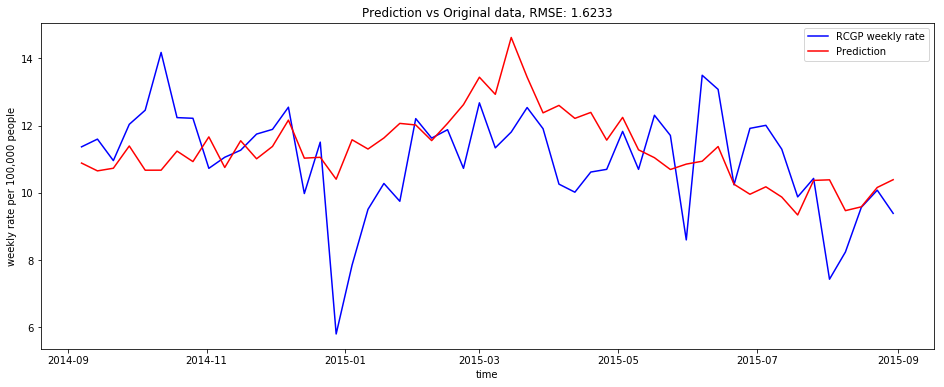

In [475]:
df6_gs = pd.DataFrame(predict_y_6, index=y_test_6.index, columns=['Prediction'])
plt.plot(y_test_6, color='blue',label='RCGP weekly rate')
plt.plot(df6_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_6_gs = np.sqrt(np.mean((y_test_6.values - df6_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_6_gs)

In [476]:
mean_absolute_error(y_test_6,df6_gs)

1.2561420489456618

In [477]:
mean_squared_error(y_test_6,df6_gs)

2.6351571051989073

In [478]:
metrics(y_test_6,df6_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.290187,2.635157,1.623317,1.256142,12.526718


In [479]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
lr = LinearRegression()
srm = StackingCVRegressor(regressors=[clf_6, rm1,rm2], meta_regressor=lr, cv=3)

In [480]:
from sklearn.model_selection import cross_val_score

rm1.fit(X=x_train_6.values,y=y_train_6.values.reshape(522,))
rm2.fit(X=x_train_6.values,y=y_train_6.values.reshape(522,))
rm3.fit(X=x_train_6.values,y=y_train_6.values.reshape(522,))
srm.fit(X=x_train_6.values,y=y_train_6.values.reshape(522,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

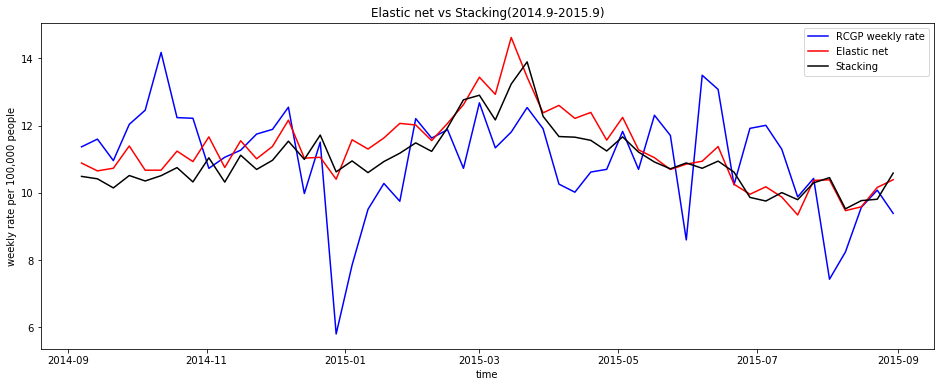

In [481]:
pre6 = srm.predict(x_test_6.values)
df6 = pd.DataFrame(pre6, index=y_test_6.index, columns=['Prediction'])

plt.plot(y_test_6, color='blue',label='RCGP weekly rate')
plt.plot(df6_gs, color = 'red', label = 'Elastic net')
plt.plot(df6, color='black', label ='Stacking')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_6_gs = np.sqrt(np.mean((y_test_6.values - df6.values)**2))
plt.title('Elastic net vs Stacking(2014.9-2015.9)')

In [482]:
mean_absolute_error(y_test_6,df6)

1.2398659670103931

In [483]:
mean_squared_error(y_test_6,df6)

2.4958366094712292

In [484]:
metrics(y_test_6,df6)

,r,MSE,RMSE,MAE,MAPE
0,0.250998,2.495837,1.579822,1.239866,12.229753


### 7th prediction

In [218]:
# 2004.9.1-2015.9.1 (11 years) -> 2015.9.1-2016.7.31
train_line_7 = pd.date_range(start= '2004-09-01', end='2015-09-01')
test_line_7 = pd.date_range(start='2015-09-01',end = '2016-07-31')
x_train_7 = gt_data.loc[train_line_7,:].dropna(0)
y_train_7 = rcgp_data.loc[train_line_7,:].dropna(0)
x_test_7 = gt_data.loc[test_line_7,:].dropna(0)
y_test_7 = rcgp_data.loc[test_line_7,:].dropna(0)


In [233]:
# 2004.9.1-2015.9.1 -> 2015.9.1-2016.7.31
from sklearn.model_selection import GridSearchCV
# parameters = {'alpha':[0,10,20,30,40,50,60,70,80,90,100],'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
# parameters = {'alpha':np.arange(1,200,0.1),'l1_ratio':[0.5]}
parameters = {'alpha':[3],'l1_ratio':[0.5]}
mycv7 = TimeSeriesSplit(n_splits = 11)
#clf = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv7)
clf_7 = GridSearchCV(ElasticNet(fit_intercept= True,max_iter=10000,tol =0.000001),param_grid=parameters,
                     scoring=make_scorer(mean_absolute_error))
clf_7.fit(X = x_train_7, y = y_train_7)
predict_y_7 = clf_7.best_estimator_.predict(x_test_7)
predict_y_7

array([ 10.65635591,  10.78173599,  10.84307746,  11.1317541 ,
        10.43429775,  11.11119669,  10.66532684,  11.01423458,
        11.91319744,  11.24677915,  11.40276806,  11.41862643,
        10.98067686,  11.17569706,  10.67710126,  10.69417245,
        10.51002409,  10.66250714,  11.73298883,  11.28279526,
        10.47309613,  11.06745075,  11.01993642,  11.7940142 ,
        12.09138348,  12.821799  ,  12.23744633,  12.94681338,
        13.26780508,  12.30773304,  12.3309077 ,  12.11837351,
        11.93503114,  11.86442639,  10.98397576,  10.26093872,
        11.0931214 ,  10.6022461 ,  10.28404772,  10.58091917,
        10.87770615,  10.58852866,  10.24514456,  10.15202157,
        10.3051158 ,  11.14028941,  10.97090655,  10.34669984])

In [234]:
clf_7.best_params_

{'alpha': 3, 'l1_ratio': 0.5}

In [235]:
weight_7 = clf_7.best_estimator_.coef_
pd.DataFrame(weight_7.reshape(1,62), columns= x_train_7.columns)

,Abdominal cramps: (England),Abdominal pain: (England),aching limbs: (England),Adenovirus: (England),anti nausea: (England),Antibiotics: (England),autumn: (England),barbecue: (England),bellyache: (England),bloody diarrhoea: (England),Diarrhea: (England),Diarrhoea: (England),Diarrhoea and vomiting: (England),Dulcolax: (England),E coli: (England),emesis: (England),feel sick: (England),fever: (England),Food poisoning: (England),Gastritis: (England),Gastro intestinal: (England),Gastroenteritis: (England),gastroenteritis contagious: (England),gastroenteritis NHS: (England),Gastroenteritis symptoms: (England),Gastrointestinal: (England),GI: (England),Hand Hygiene: (England),headache: (England),infants: (England),microorganisms: (England),Nausea: (England),NHS gastroenteritis: (England),Norovirus: (England),Norwalk: (England),Norwalk virus: (England),Ondansetron: (England),Oral rehydration therapy: (England),painful stomach cramps: (England),Parasites: (England),raw food: (England),raw meat: (England),rota virus: (England),Rotavirus vaccine: (England),Rotavirus: (England),Salmonella: (England),SASP: (England),seafood: (England),spring: (England),stomach ache: (England),stomach flu: (England),stomachache: (England),summer: (England),Symptoms of gastroenteritis: (England),throw up: (England),viral gastroenteritis: (England),vomit: (England),vomiting: (England),winter: (England),Winter vomiting: (England),Winter vomiting bug: (England),Zofran: (England)
0,-0.0,-0.036109,0.0,-0.0,-0.008051,0.0,-0.0,-0.014304,0.0,0.000256,0.031857,0.0,0.008305,-0.018685,0.007211,0.0,-0.017563,0.0,0.0,-0.0,-0.0,0.022668,0.0,0.0,-0.0,0.003039,-0.0,-0.0,0.0,0.0,0.000425,-0.0,0.0,0.002352,-0.0,0.0,-0.0,0.0044,0.0,-0.0,-0.008759,-0.0,0.008534,-0.004178,0.03168,-0.0,0.0,-0.0,0.046728,-0.0,0.0,0.0,0.0,0.000534,-0.0,-0.003357,0.003553,0.000947,0.0,0.005983,0.0,-0.002084


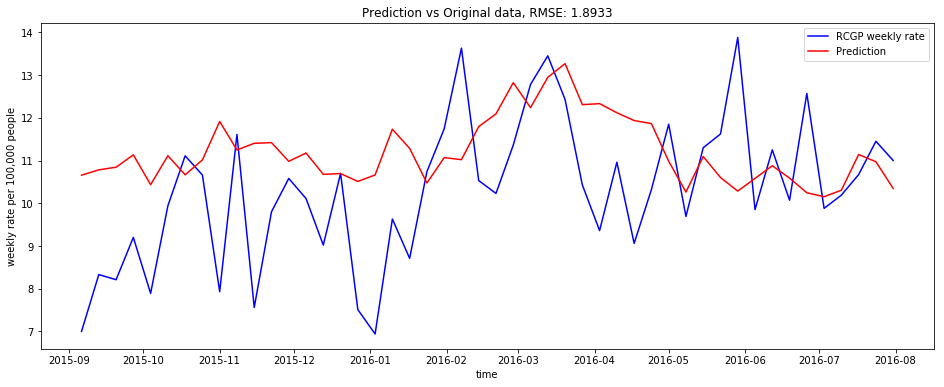

In [236]:
df7_gs = pd.DataFrame(predict_y_7, index=y_test_7.index, columns=['Prediction'])
plt.plot(y_test_7, color='blue',label='RCGP weekly rate')
plt.plot(df7_gs, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_7_gs = np.sqrt(np.mean((y_test_7.values - df7_gs.values)**2))
plt.title('Prediction vs Original data, RMSE: %.4f'% rmse_7_gs)

In [237]:
mean_absolute_error(y_test_7,df7_gs)

1.5034052551524593

In [238]:
mean_squared_error(y_test_7,df7_gs)

3.5847033644419048

In [239]:
metrics(y_test_7,df7_gs)

,r,MSE,RMSE,MAE,MAPE
0,0.196825,3.584703,1.893331,1.503405,16.232602


In [240]:
rm1 = SVR()
rm2 = RandomForestRegressor(random_state=1)
rm3 = XGBRegressor()
lr = LinearRegression()
srm = StackingCVRegressor(regressors=[clf_7, rm1,rm2], meta_regressor=lr, cv=3)

In [241]:
from sklearn.model_selection import cross_val_score

rm1.fit(X=x_train_7.values,y=y_train_7.values.reshape(574,))
rm2.fit(X=x_train_7.values,y=y_train_7.values.reshape(574,))
rm3.fit(X=x_train_7.values,y=y_train_7.values.reshape(574,))
srm.fit(X=x_train_7.values,y=y_train_7.values.reshape(574,))


StackingCVRegressor(cv=3,
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          regressors=[GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-06, warm_start=False),
       fit_...n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

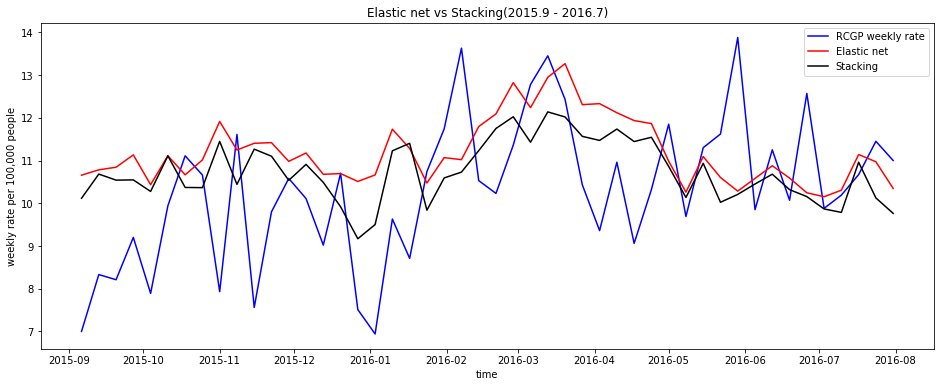

In [242]:
pre7 = srm.predict(x_test_7.values)
df7 = pd.DataFrame(pre7, index=y_test_7.index, columns=['Prediction'])

plt.plot(y_test_7, color='blue',label='RCGP weekly rate')
plt.plot(df7_gs, color = 'red', label = 'Elastic net')
plt.plot(df7, color = 'black', label = 'Stacking')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_7_gs = np.sqrt(np.mean((y_test_7.values - df7.values)**2))
plt.title('Elastic net vs Stacking(2015.9 - 2016.7)')

In [243]:
mean_absolute_error(y_test_7,df7)

1.4113545553256479

In [244]:
mean_squared_error(y_test_7,df7)

2.9242774713567781

In [245]:
metrics(y_test_7,df7)

,r,MSE,RMSE,MAE,MAPE
0,0.205881,2.924277,1.710052,1.411355,14.798501


## total

In [116]:
# df_gs = df1_gs.append(df2_gs)
# df_gs = df_gs.append(df3_gs)
# df_gs = df_gs.append(df4_gs)
# df_gs = df_gs.append(df5_gs)
# df_gs = df_gs.append(df6_gs)
# df_gs = df_gs.append(df7_gs)
# df_gs

In [117]:
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)
df = df.append(df5)
df = df.append(df6)
df = df.append(df7)
#df

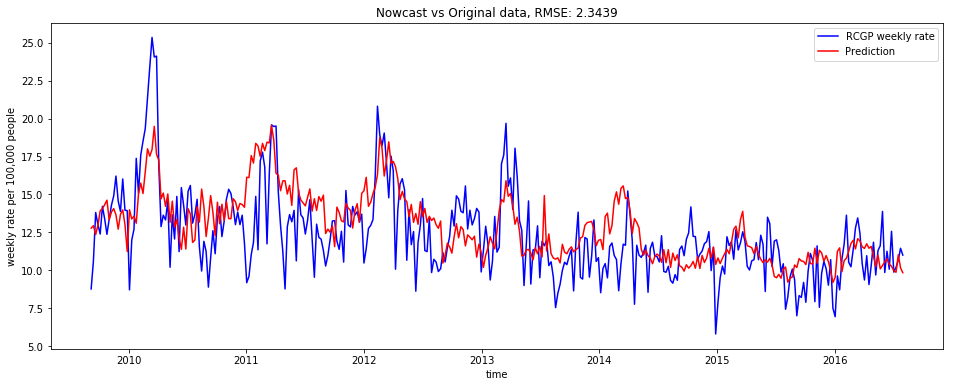

In [118]:
rcgp_line = pd.date_range(start='2009-09-01',end = '2016-07-31')
rcgp_2010_2016 = rcgp_data.loc[rcgp_line,:].dropna(0)

compare = df.join(rcgp_2010_2016)

plt.plot(rcgp_2010_2016, color='blue',label='RCGP weekly rate')
plt.plot(df, color = 'red', label = 'Prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('weekly rate per 100,000 people')

rmse_all_gs = np.sqrt(np.mean((compare['weekly_rate'] - compare['Prediction'])**2))
plt.title('Nowcast vs Original data, RMSE: %.4f'% rmse_all_gs)

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = compare['weekly_rate']
y_pred = compare['Prediction']
mean_absolute_error(y_true, y_pred)

1.7937468134687566

In [120]:
mean_squared_error(y_true, y_pred)

5.4937446303374555

## pca


In [121]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit(gt_data)

In [122]:
# pca_data = pca.transform(gt_data)
# pca_data = pd.DataFrame(pca_data, index = gt_data.index, columns=['f1', 'f2', 'f3'])
# pca_data

In [123]:
# corr_table = rcgp_data.join(pca_data).corr()
# corr_table

In [124]:
# print(pca.explained_variance_ratio_) 

In [125]:
# pca_train_line_1 = pd.date_range(start= '2004-09-01', end='2009-09-01')
# pca_test_line_1 = pd.date_range(start='2009-09-01',end = '2010-09-01')
# pca_x_train_1 = pca_data.loc[pca_train_line_1,:].dropna(0)
# pca_y_train_1 = rcgp_data.loc[pca_train_line_1,:].dropna(0)
# pca_x_test_1 = pca_data.loc[pca_test_line_1,:].dropna(0)
# pca_y_test_1 = rcgp_data.loc[pca_test_line_1,:].dropna(0)


# parameters = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]}
# mycv1 = TimeSeriesSplit(n_splits = 5)
# clf = GridSearchCV(ElasticNet(),param_grid=parameters, cv = mycv1)
# #clf = GridSearchCV(ElasticNet(),param_grid=parameters)
# clf.fit(X = pca_x_train_1, y = pca_y_train_1)
# predict_y_p1 = clf.best_estimator_.predict(pca_x_test_1)
# predict_y_p1

In [126]:
# clf.best_params_

In [127]:
# pca1 = pd.DataFrame(predict_y_p1, index=pca_y_test_1.index, columns=['Prediction'])
# plt.plot(pca_y_test_1, color='blue',label='RCGP weekly rate')
# plt.plot(pca1, color = 'red', label = 'Prediction')
# plt.legend()
# plt.xlabel('time')
# plt.ylabel('weekly rate per 100,000 people')

# rmse1 = np.sqrt(np.mean(pca_y_test_1.values - pca1.values)**2)
# plt.title('Prediction vs Original data, RMSE: %.4f'% rmse1)